## Exploratory Data Analysis
---

This notebook contains exploratory data analysis of the Scania Trucks Air Pressure System (APS) predictive maintenance dataset, obtained from [UCI's data repository](https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set()

In [98]:
# # Run this only once:

# # Data is provided in a CSV with first 20 rows as general information in text format
# df_test = pd.read_csv(r'./data/aps_failure_test_set.csv', skiprows=20)
# df_train = pd.read_csv(r'./data/aps_failure_training_set.csv', skiprows=20)

# # Replace 'na' with np.nan & rewrite out CSV (data only)
# df_test.replace('na', np.nan, inplace=True)
# df_test.to_csv(r'./data/aps_failure_test_set_data_only.csv', index=False)

# df_train.replace('na', np.nan, inplace=True)
# df_train.to_csv(r'./data/aps_failure_training_set_data_only.csv', index=False)

In [2]:
df_test = pd.read_csv(r'./data/aps_failure_test_set_data_only.csv')
df_train = pd.read_csv(r'./data/aps_failure_training_set_data_only.csv')

In [11]:
print('df_train: ', df_train.shape)
print('df_test: ', df_test.shape)

df_train:  (60000, 171)
df_test:  (16000, 171)


## Graphical Exploration
---

Due to the large amount of features, plots are written to a folder and viewed outside of this notebook.

Example plots are shown below in the Conclusions & Thoughts section.

### Plot Pareto Frequency Plots
NaN and zero values are ignored as they make up the bulk of values for most features

In [ ]:
output_dir = r'./plots/barplot/'

df = df_train.fillna(0)

for feat in df.columns.drop('class'):
    # Create figure
    fig = plt.figure(figsize=(10, 8))

    # barplot
    df[feat][df[feat] != 0.0].value_counts().iloc[:10].plot(kind='bar', rot=45)

    # Plot labels
    plt.title('Top 10 Frequent Values - %s - Excl. NaN & Zero' % feat, fontsize=16)
    plt.xlabel('');
    plt.ylabel('Frequency');

    # Save plot
    fig.savefig(os.path.join(output_dir, 'barplot_' + feat + '.jpg'))
    plt.close(fig)

### Plot Boxplots - All Features

In [23]:
output_dir = r'./plots/boxplot/'

for feat in df_train.columns.drop('class'):
    # Create figure
    fig = plt.figure(figsize=(10, 8))

    # Boxplot
    sns.boxplot(data=df_train[feat]);

    # Plot labels
    plt.xlabel(feat);
    plt.ylabel('');
    plt.title('Boxplot: %s' % feat, fontsize=16);

    # Save plot
    fig.savefig(os.path.join(output_dir, 'boxplot_' + feat + '.jpg'))
    plt.close(fig)

### Plot ECDF - All Features
ECDF = Empirical Cumulative Distribution Function

In [24]:
def ecdf(data):
    n = len(data)

    # x-data for the ecdf: x
    x = np.sort(data)

    # y-data for the ecdf: y
    y = np.arange(1, n+1) / n

    return x, y

In [25]:
output_dir = r'./plots/ecdf/'

for feat in df_train.columns.drop('class'):
    # Create figure
    fig = plt.figure(figsize=(10, 8))

    # ECDF
    x, y = ecdf(df_train[feat])
    plt.plot(x, y, marker='.', linestyle='None');

    # Plot labels
    plt.xlabel(feat);
    plt.ylabel('ECDF');
    plt.title('ECDF: %s' % feat, fontsize=16);

    # Save plot
    fig.savefig(os.path.join(output_dir, 'ECDF_' + feat + '.jpg'))
    plt.close(fig)

### Correlation Matrix

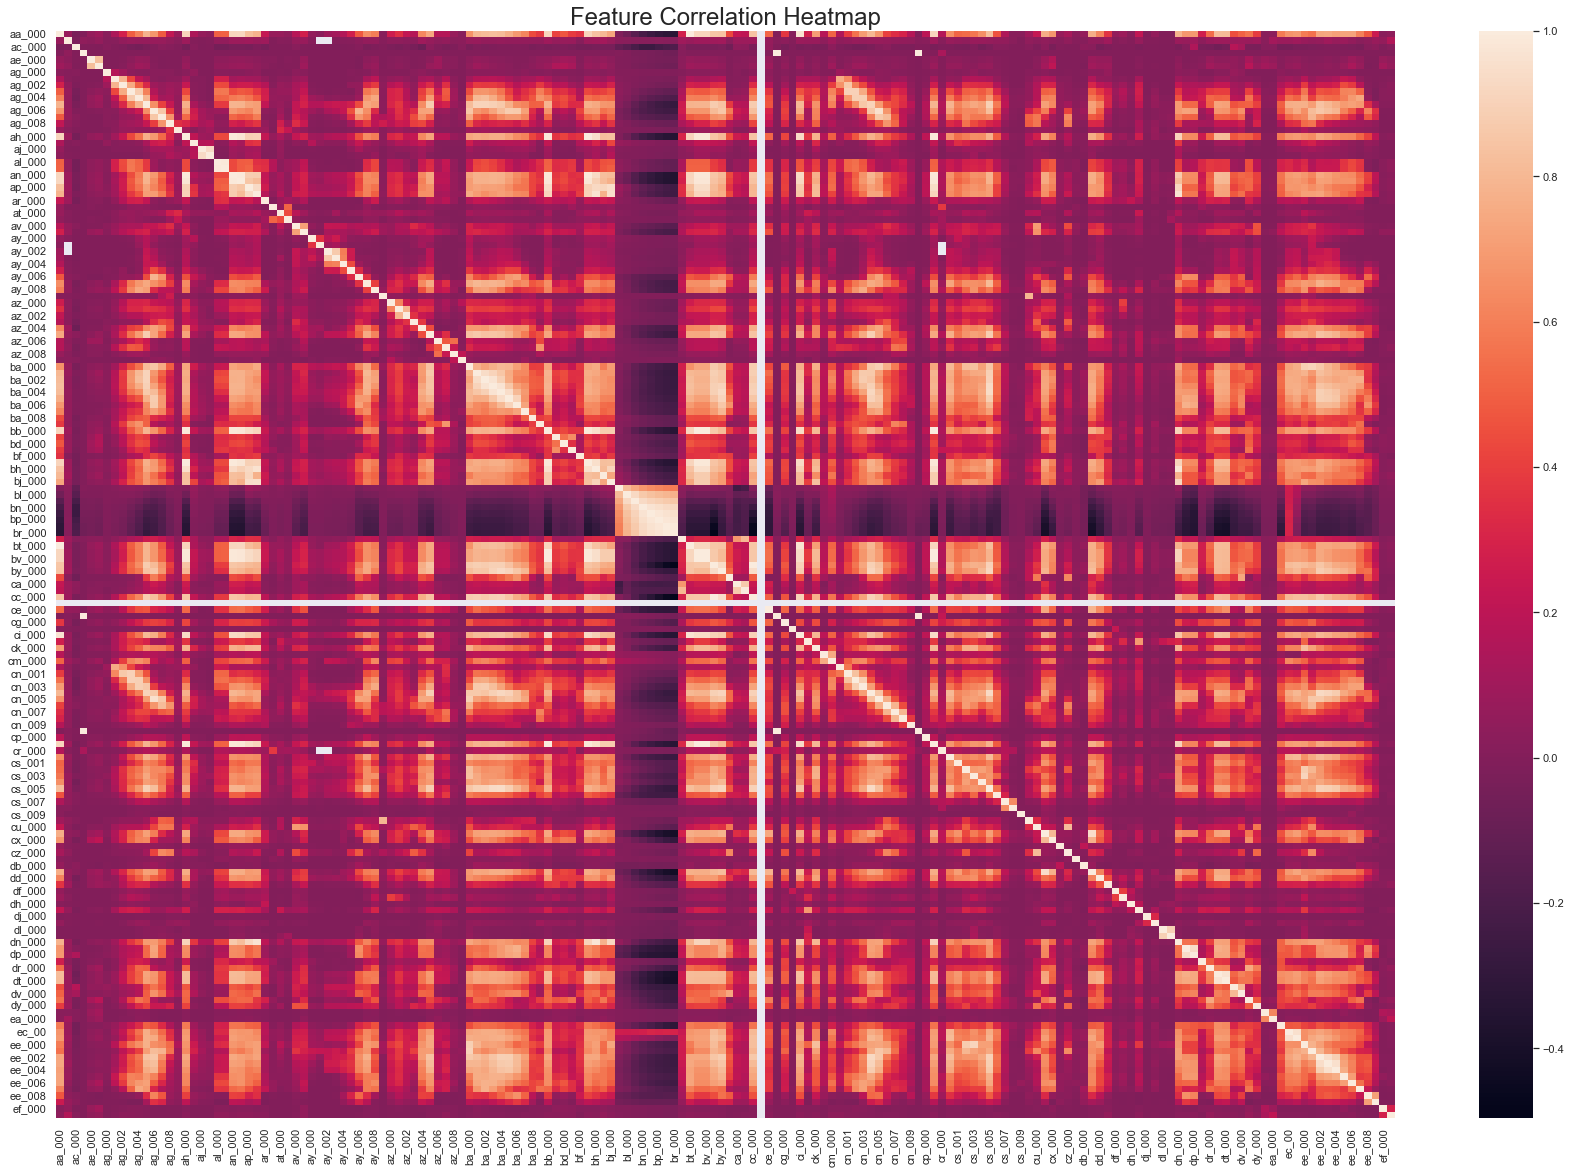

In [3]:
# Plot feature correlation heat map
plt.figure(figsize=(30, 20))
hm = sns.heatmap(df_train.corr());
hm.set_title("Feature Correlation Heatmap", fontsize=24);

In [50]:
# Create correlation matrix
corr_matrix = df_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print('Total Correlated Features: %i' % len(to_drop))
print('Correlated Features: %s' % to_drop)

# Find correlated features
corr_feat_dict = {}
for corr_feat in to_drop:
    corr_feat_dict[corr_feat] = upper[corr_feat][upper[corr_feat] > 0.95].index.to_list()

Total Correlated Features: 26
Correlated Features: ['am_0', 'an_000', 'ao_000', 'ba_003', 'ba_004', 'bb_000', 'bg_000', 'bh_000', 'bj_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bt_000', 'bu_000', 'bv_000', 'cc_000', 'cf_000', 'ci_000', 'cn_005', 'co_000', 'cq_000', 'dn_000', 'dt_000', 'ed_000', 'ee_004']


### Plot Correlated Features (Graphical Verification)

In [69]:
output_dir = r'./plots/ecdf/'

def plot_ecdf(data):
    x, y = ecdf(data)
    plt.plot(x, y, marker='.', linestyle='none', markersize=2, label=data.name)
    pass


# Plot ECDFs for correlated features
for key in corr_feat_dict.keys():
    # Create figure
    fig = plt.figure(figsize=(10, 8))

    # Plot boxplot of feature
    plot_ecdf(df_train[key])

    # Get correlated features
    corr_feats = corr_feat_dict[key]

    for corr_feat in corr_feats:
        plot_ecdf(df_train[corr_feat])

    plt.title('Correlated Features for %s' % key, fontsize=16)
    plt.ylabel('ECDF')
    plt.legend()
    plt.savefig(os.path.join(output_dir, 'correlated_ecdfs_' + key + '.jpg'))
    plt.close(fig)

### Visualization via PCA

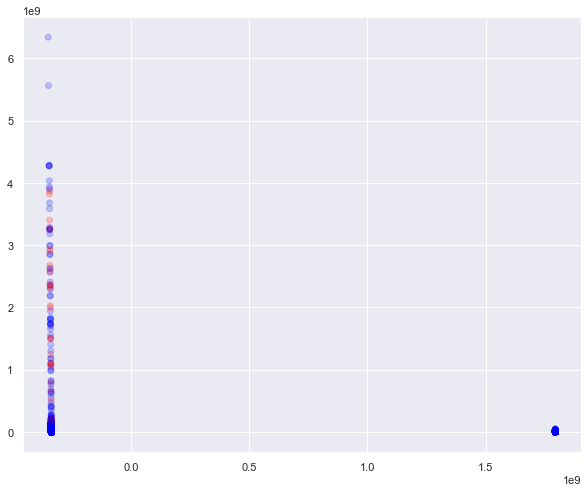

In [36]:
pca = PCA(n_components=2)
x_t = pca.fit_transform(df_train.drop('class', axis=1).fillna(0))

colors = ['red' if x == 'pos' else 'blue' for x in df_train['class'].tolist()]
fig = plt.figure(figsize=(10, 8))
plt.scatter(x_t[:, 0], x_t[:, 1], c=colors, alpha=0.2);

PCA did not work very well on this dataset

## Quantitative Exploration
---

In [ ]:
pd.set_option('display.max_columns', 1000)
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,703300.0,755876.0,0.0,5374.0,2108.0,4114.0,12348.0,615248.0,5526276.0,2378.0,4.0,0.0,0.0,2328746.0,1022304.0,415432.0,287230.0,310246.0,681504.0,1118814.0,3574.0,0.0,0.0,6700214.0,0.0,10.0,108.0,50.0,2551696.0,97518.0,947550.0,799478.0,330760.0,353400.0,299160.0,305200.0,283680.0,NaN,NaN,NaN,178540.0,76698.08,6700214.0,6700214.0,6599892.0,43566.0,68656.0,54064.0,638360.0,6167850.0,1209600.0,246244.0,2.0,96.0,0.0,5245752.00,0.0,916567.68,6.0,1924.0,0.0,0.0,0.0,118196.0,1309472.0,3247182.0,1381362.0,98822.0,11208.0,1608.0,220.0,240.0,6700214.0,NaN,10476.0,1226.0,267998.0,521832.0,428776.0,4015854.0,895240.0,26330.0,118.0,0.0,532.0,734.0,4122704.0,51288.0,0.0,532572.0,0.0,18.0,5330690.0,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,1996924.0,99560.0,0.0,7336.0,7808.0,13776.0,13086.0,1010074.0,1873902.0,14726.0,6.0,0.0,0.0,1378576.0,447166.0,199512.0,154298.0,137280.0,138668.0,165908.0,229652.0,87082.0,4708.0,3646660.0,86.0,454.0,364.0,350.0,1393352.0,49028.0,688314.0,392208.0,341420.0,359780.0,366560.0,NaN,NaN,NaN,NaN,NaN,6700.0,33057.51,3646660.0,3646660.0,3582034.0,17733.0,260120.0,115626.0,6900.0,2942850.0,1209600.0,0.0,NaN,NaN,NaN,2291079.36,0.0,643536.96,0.0,0.0,0.0,0.0,38.0,98644.0,1179502.0,1286736.0,336388.0,36294.0,5192.0,56.0,NaN,0.0,3646660.0,NaN,6160.0,796.0,164860.0,350066.0,272956.0,1837600.0,301242.0,9148.0,22.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,870456.0,239798.0,1450312.0,0.0,1620.0,1156.0,1228.0,34250.0,1811606.0,710672.0,34.0,0.0,0.0,0.0,790690.0,672026.0,332340.0,254892.0,189596.0,135758.0,103552.0,81666.0,46.0,0.0,2673338.0,128.0,202.0,576.0,4.0,1234132.0,28804.0,160176.0,139730.0,137160.0,13064

In [ ]:
df_train['class'].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

As expected, this problem suffers from class imbalance (significantly more negative instances than positive instances)

In [12]:
print('Number of NaN values (Top 10):')
df_train.isna().sum().sort_values(ascending=False)[:10]

Number of NaN values (Top 10):


br_000    49264
bq_000    48722
bp_000    47740
bo_000    46333
ab_000    46329
cr_000    46329
bn_000    44009
bm_000    39549
bl_000    27277
bk_000    23034
dtype: int64

In [13]:
df_train['br_000'].value_counts().iloc[:10]

1310700.0    3886
0.0          1813
205800.0        8
292360.0        7
288400.0        7
229360.0        6
175700.0        6
285980.0        6
181280.0        6
143760.0        5
Name: br_000, dtype: int64

In [ ]:
print('Number of NaN values (Bottom 10):')
df_train.replace('na', np.nan).isna().sum().sort_values(ascending=True)[:10]

Number of NaN values (Bottom 10):


class       0
aa_000      0
bt_000    167
ck_000    338
cj_000    338
ci_000    338
by_000    473
aq_000    589
bi_000    589
bj_000    589
dtype: int64

All features (except aa_000) have some NaN values. There are many features where >50% of values are NaN.

In [ ]:
df_train.drop('class', axis=1).describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,6.000000e+04,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.935500e+04,5.937100e+04,5.937100e+04,5.560000e+04,5.935800e+04,5.937100e+04,5.935800e+04,5.941100e+04,5.935800e+04,5.941100e+04,57277.000000,5.937100e+04,5.937100e+04,5.937100e+04,57500.000000,57499.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,59329.000000,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.935500e+04,57275.000000,57273.000000,57497.000000,57500.000000,5.935800e+04,5.935800e+04,5.941100e+04,5.941100e+04,3.696600e+04,3.272300e+04,2.045100e+04,1.599100e+04,1.366700e+04,1.226000e+04,1.127800e+04,1.073600e+04,5.927400e+04,5.983300e+04,5.930900e+04,5.930900e+04,5.674300e+04,5.952700e+04,5.727700e+04,55644.000000,5.927400e+04,5.674500e+04,59324.0,5.749800e+04,4.513900e+04,45139.000000,45139.000000,5.966200e+04,5.966200e+04,5.966200e+04,50447.000000,50123.000000,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,4.513900e+04,57276.000000,5.930900e+04,13671.000000,59331.000000,59331.000000,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,46192.000000,46192.000000,4.619200e+04,4.619200e+04,46192.000000,4.619200e+04,46192.000000,46192.000000,4.619200e+04,57497.000000,57276.000000,5.599200e+04,5.599200e+04,5.599200e+04,5.599400e+04,55993.000000,5.599300e+04,5.599200e+04,5.599100e+04,5.930900e+04,5.727600e+04,57274.000000,5.727400e+04,5.727400e+04,5.727300e+04,57273.000000,5.727400e+04,5.727400e+04,5.727700e+04,5.727600e+04,57277.000000,57277.000000,5.599300e+04,49761.000000,50447.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,4.370966e+05,1.108374e+06,1.657818e+06,4.993098e+05,3.556989e+04,5.114753e+03,1.809931e+06,9.016965e+03,1.143675e+03,9.794900e+02,5.913048e+04,9.328133e+04,3.461037e+06,3.002440e+06,1.004160e+06,4.424045e+05,0.496918,1.267365e+02,5.072046e+03,2.305804e+02,1117.825913,374.327380,1.221165e+04,1.019012e+04,1.097500e+04,7.225784e+03,1.056600e+04,1.119791e+05,1.078551e+06,1.546032e+06,1.051123e+06,1.162622e+03,7.849608e+03,4.420992e+03,8.066082e+03,8.724082e+04,1.476897e+06,2.1

In [ ]:
df_train.astype('object').describe()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000,60000,13671.0,56665.0,45139.0,57500.0,57500.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59355.0,59371.0,59371.0,55600.0,59358.0,59371.0,59358.0,59411.0,59358.0,59411.0,57277.0,59371.0,59371.0,59371.0,57500.0,57499.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59312.0,59312.0,59312.0,59312.0,59312.0,59312.0,59312.0,59312.0,59312.0,59312.0,59355.0,57275.0,57273.0,57497.0,57500.0,59358.0,59358.0,59411.0,59411.0,36966.0,32723.0,20451.0,15991.0,13667.0,12260.0,11278.0,10736.0,59274.0,59833.0,59309.0,59309.0,56743.0,59527.0,57277.0,55644.0,59274.0,56745.0,59324.0,57498.0,45139.0,45139.0,45139.0,59662.0,59662.0,59662.0,50447.0,50123.0,59313.0,59313.0,59313.0,59313.0,59313.0,59313.0,59313.0,59313.0,59313.0,59313.0,45139.0,57276.0,59309.0,13671.0,59331.0,59331.0,59331.0,59331.0,59331.0,59331.0,59331.0,59331.0,59331.0,59331.0,46192.0,46192.0,46192.0,46192.0,46192.0,46192.0,46192.0,46192.0,46192.0,57497.0,57276.0,55992.0,55992.0,55992.0,55994.0,55993.0,55993.0,55992.0,55991.0,59309.0,57276.0,57274.0,57274.0,57274.0,57273.0,57273.0,57274.0,57274.0,57277.0,57276.0,57277.0,57277.0,55993.0,49761.0,50447.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,59329.0,57276.0,57277.0
unique,2,22095,29.0,2061.0,1886.0,333.0,418.0,154.0,617.0,2422.0,7879.0,23071.0,40797.0,40615.0,32125.0,18932.0,5355.0,43571.0,4055.0,894.0,159.0,9017.0,10582.0,48204.0,47723.0,44672.0,34921.0,68.0,21.0,3511.0,56.0,3860.0,2215.0,466.0,919.0,986.0,1032.0,1767.0,19696.0,34628.0,38651.0,37822.0,447.0,9184.0,7378.0,9064.0,21530.0,34077.0,44601.0,12306.0,3876.0,1271.0,336.0,44840.0,40164.0,35958.0,32914.0,30673.0,29593.0,29281.0,25166.0,11816.0,6797.0,49392.0,2807.0,3565.0,3918.0,1098.0,43568.0,25240.0,42098.0,38359.0,12917.0,11969.0,9037.0,7096.0,5838.0,4968.0,4276.0,3806.0,12834.0,45480.0,49349.0,49346.0,52848.0,22627.0,16547.0,28318.0,30170.0,43859.0,1.0,22075.0,525.0,646.0,2.0,45964.0,7617.0,45043.0,972.0,2123.0,1530.0,5419.0,14789.0,34110.0,42086.0,38554.0,32426.0,21996.0,10117.0,3055.0,1860.0,2315.0,49347.0,74.0,9297.0,3343.0,28277.0,35193.0,34558.0,42558.0,40916.0,17300.0,773.0,53.0,2617.0,3519.0,32928.0,25236.0,748.0,10727.0,263.0,146.0,33177.0,6563.0,1893.0,402.0,1313.0,1055.0,5618.0,72.0,256.0,181.0,221.0,21098.0,20514.0,11568.0,8110.0,6682.0,26312.0,15910.0,28495.0,30139.0,14735.0,6311.0,47.0,134.0,27831.0,31141.0,3930.0,41815.0,38245.0,34488.0,31711.0,35188.0,36288.0,31795.0,30469.0,24213.0,9724.0,28.0,49.0
top,neg,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

The data description states that features consists of:

1. Single numerical counters, e.g. number of cycles

2. Histograms consisting of bins with different conditions, e.g. bins of temperature ranges


In both cases, it should be safe to assume these are continuous variables and not categorical variables. It is not stated, but assumed that bin numbering is monotonically increasing.

In [3]:
df = df_train.astype('object').describe().transpose()

print('Features with least amount of unique values:')
df['unique'].sort_values(ascending=True)[:10]

Features with least amount of unique values:


cd_000     1.0
class        2
ch_000     2.0
as_000    21.0
ef_000    28.0
ab_000    29.0
dz_000    47.0
eg_000    49.0
cs_009    53.0
au_000    56.0
Name: unique, dtype: object

In [ ]:
df_train['ch_000'].value_counts()

0.0    45129
2.0       10
Name: ch_000, dtype: int64

In [ ]:
df_train['as_000'].value_counts().sort_index()

0.0          59350
4.0              1
790.0            1
1156.0           1
6268.0           1
13752.0          2
21748.0          1
31518.0          1
63712.0          1
113724.0         1
128844.0         1
201306.0         1
320346.0         1
357260.0         1
368184.0         1
489122.0         1
647060.0         1
693990.0         1
1150508.0        1
1246190.0        1
1655240.0        1
Name: as_000, dtype: int64

In [19]:
df_train['as_000'].isna().sum()

629

The data description also states that 7/171 features are of type 2 (histograms), but does not provide details on which features.

Shown above are the value counts for the 2 features with the least amount of unique values.

## Conclusions & Thoughts
---

* There are alot of features in this dataset with a significant amount of NaN values. One challenges will be dealing with NaN values, as many features also contain a zero value. 

* e.g., an NaN value is just missing data, whereas a zero value could mean something such as temperature <20 degC

* For example, the feature shown at the end of the previous section, as_000, has a significant amount of 0 values as well as 629 NaN values.

* Graphical exploration also shows a wide range of distributions going from feature to feature. Three examples of different feature distributions are shown below.

![image](./plots/ecdf/ecdf_bq_000.jpg)
![image](./plots/ecdf/ecdf_au_000.jpg)
![image](./plots/ecdf/ecdf_cb_000.jpg)

* bq_000 resembles a binned histogram where the first and last bins denote an open criteria, e.g. temperature <20 degC and temperature >20 degC.

* au_000 resembles a on/off feature, similar to a check engine light (mainly OFF, but in certain cases, ON).

* cb_000 resembles a continuous feature (varies over a wide range), similar to an odometer of sorts.

![image](./plots/boxplot/boxplot_bq_000.jpg)
![image](./plots/boxplot/boxplot_au_000.jpg)
![image](./plots/boxplot/boxplot_cb_000.jpg)

* Boxplots are not as useful for this dataset as others, because the numeric value of the features do not mean much as they have been anonymized. 

* One interesting take-away is that for the ON/OFF features, when they are ON, there is still a small range of values, as shown above. This would resemble an error code of sorts, where during normal operations, it is "OFF" or "NO READING". When it is "ON", it can have a variety of codes denoting why it is on.

* There are also ~26 features that are correlated with others. An overlay of their ECDF provides graphical confirmation of this correlation, though no p-value is calculated.

![image](./plots/ecdf/correlated_ecdfs_ao_000.jpg)
![image](./plots/ecdf/correlated_ecdfs_bb_000.jpg)
![image](./plots/ecdf/correlated_ecdfs_bu_000.jpg)